# Euroleague games 2003-2019


![](https://www.baskonia.com/wp-content/uploads/2020/04/el-1024x378.png)

The aim of this notebook is to examine the "Basketball-Euroleague RESULTS 2003-2020" dataset to find some interesting information and to see the differences between teams or trends in the game over the years. Finally we'll estimate the final difference using different ML techniques.

# 1. Importing needed libraries and initial exploration.

In [ ]:
import numpy as np 
import pandas as pd 
import os
import statistics 
#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
#Tools for predictive data analysis
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
dataset = pd.read_csv('/kaggle/input/euroleague-basketball-results-20032019/euroleague_dset_csv_03_20_upd.csv')
dataset

The dataset includes information related to all the games from 2003 to 2019. It contains information on each game, with the following colums:
* DATE = Date
* HT = Home Team
* AT = Away Team
* WINNER = Team won the game
* HS = Home Score
* AS = Away Score
* Q1H = 1st quarter home score
* Q1A = 1st quarter away score
* Q2H = …
* Q2A = …
* Q3H = …
* Q3A = …
* Q4H = …
* Q4A = …
* OTH = Overtime home 
* OTA = Overtime away 
* P1H = 1st part home score
* P1A = 1st part away score
* P2H = 2nd part home score
* P2A = 2nd part away score
* P1T = part 1 total
* P2T = part 2 total
* HTT = half time total (=P1T)
* FTT = full time total
* GAPA1Q = Absolute number of gap between teams in points after 1st quarter
* GAPA2Q = Absolute number of gap between teams in points after 2nd quarter
* GAPA3Q = Absolute number of gap between teams in points after 3rd quarter
* GAPA4Q = Absolute number of gap between teams in points after 4rd quarter


In [ ]:
dataset.info()

In [ ]:
print(dataset.describe())
print(dataset.describe(include=np.object))

# 2. Home/Away ratio victories.

What is the difference between top teams and average teams? Is it their strenght playing as local? We'll focus on the teams with a number of victories equal or greater than 10. Before starting our analysis we need some data cleaning.

In [ ]:
# Some teams have different names within the years, let's fix it.
rename = {'Tau Ceramica':'Baskonia','Fenerbahce Ulker':'Fenerbahce',
          'Anadolu Efes SK':'Anadolu Efes','Crvena zvezda mts':'Crvena Zvezda',
          'Khimki M.':'Khimki'} 
dataset.replace(rename,inplace = True)

In [ ]:
over_10 = dataset['WINNER'].value_counts().head(45) #The first 45 teams are above ten victories.
below_10 = dataset['WINNER'].value_counts().tail(36)#Teams below 10 victories
list_below_10 = list(below_10.index)
list_over_10 = list(over_10.index)

In [ ]:
#empty dictionary
team_victotal_ratiolocal = {'Name':[],'Victories_percentage':[],'Victories_local_percentage':[]}      

for team in list_over_10:
        total_games = dataset[(dataset['HT'] == team) | (dataset['AT'] == team)].shape[0]             
        total_victories = dataset[(dataset['WINNER'] == team)].shape[0]                               
        local_victories = dataset[(dataset['HT'] == team) & (dataset['WINNER'] == team)].shape[0]     
        team_victotal_ratiolocal['Name'].append(team)                                                               
        team_victotal_ratiolocal['Victories_percentage'].append((total_victories / total_games) * 100)              
        team_victotal_ratiolocal['Victories_local_percentage'].append((local_victories / total_victories) * 100)    


In [ ]:
df = pd.DataFrame(team_victotal_ratiolocal)     #Dataframe using the dictionary created before
df = df.sort_values(by=['Victories_percentage'])#Sorting the dataframe by 'Victories_percentage'

In [ ]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
plt.axhline(y=50, color='r', linestyle='--')
plt.xticks(rotation='vertical')
ax.bar(df['Name'],df['Victories_percentage'])
plt.title('Victories percentage',fontdict=font)
plt.show()

#second chart

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
plt.axhline(y=50, color='r', linestyle='--')
plt.xticks(rotation='vertical')
ax.bar(df['Name'],df['Victories_local_percentage'])
plt.title('Ratio Home/Away victories',fontdict=font)
plt.show()

In [ ]:
ax1 = df.plot.scatter(x = 'Victories_percentage', y = 'Victories_local_percentage', c = 'DarkBlue')
m, b = np.polyfit(df['Victories_percentage'], df['Victories_local_percentage'], 1)   # m = slope, b = intercept

plt.plot(df['Victories_percentage'], m*df['Victories_percentage'] + b)
plt.show()

We notice that the top teams win almost as much playing at home or away. Which shows us a sign of consistency, proving they can win playing anywhere. Moreover, average teams seems to struggle playing away. For instance, we'd like to stand out Strasbourg, which won 9 out 10 victories playing at home.

# 3. Winning and lossing streaks.

In [ ]:
#We change the type of the 'date' column to datetime
dataset["DATE"] = pd.to_datetime(dataset["DATE"])
dataset.sort_values(by="DATE", inplace=True)
dataset["DATE"]

Now, let's compute the highest streaks for each team over the seasons.

In [ ]:
win_max= []
loss_max =[]
max_losses= {}
max_wins = {}
max_w_l = {}
#Iterate over the teams and create a counter to compute 
#the highest winning and losing streak
for team in list_over_10:
    dataset_team = dataset[(dataset['HT'] == team) | (dataset['AT'] == team)]
    dataset_team = dataset_team[['DATE', 'HT', 'AT', 'WINNER']]
    dataset_team['WIN'] = [1 if x == team else 0 for x in dataset_team['WINNER']]
    dataset_team['LOSS'] = [0 if x == team else 1 for x in dataset_team['WINNER']]
    wins = 0
    losses = 0
    for item in dataset_team['WIN']:
        if item ==1:
            counter += 1
        else:
            counter = 0
        if counter > wins:
            wins = counter
    max_wins[team] = wins
    win_max.append(wins)
    for item in dataset_team['LOSS']:
        if item == 1:
            counter += 1
        else:
            counter = 0
        if counter > losses:
            losses = counter
    max_losses[team] = losses
    max_w_l[team] = [wins,losses]
    loss_max.append(losses)

In [ ]:
#Create a barplot using matplotlib    
plt.figure(figsize=(20, 10))
# set width of bar
barWidth = 0.4
 
# set height of bar
bars1 = win_max
bars2 = loss_max

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='g', width=barWidth, edgecolor='white', label='wins')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='white', label='losses')
 
# Add xticks on the middle of the group bars
# plt.xlabel('Teams', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], list_over_10,rotation='vertical')
 
# Create legend & Show graphic
plt.legend()
plt.show()

# 4. Scoring evolution.

The game is changing, everybody noticed it. Players are faster and shoot better. Does this create an increase in the average score per game? Let's review how the mean score has changed.

In [ ]:
#Create a new column by adding AS and HS
dataset['TS'] = dataset['HS'] + dataset['AS']
#Create a new dataset
dt_score = dataset[['DATE','TS']]
#Compute the mean for each month
dt_score = dt_score.groupby(pd.Grouper(key="DATE", freq="1M")).mean()
#Remove nulls
dt_score.dropna(inplace = True)
dt_score

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(range(0,190),dt_score['TS'])
plt.ylim(bottom = 140, top = 185) 
# plt.xticks(range(0,190), " ")
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
plt.title('Scoring Monthly 2003-2020',fontdict=font)
plt.show()

Nothing can be assured from the above graph, but in recent years there seems to be a slight trend towards a higher score.

# 5. Final difference prediction.

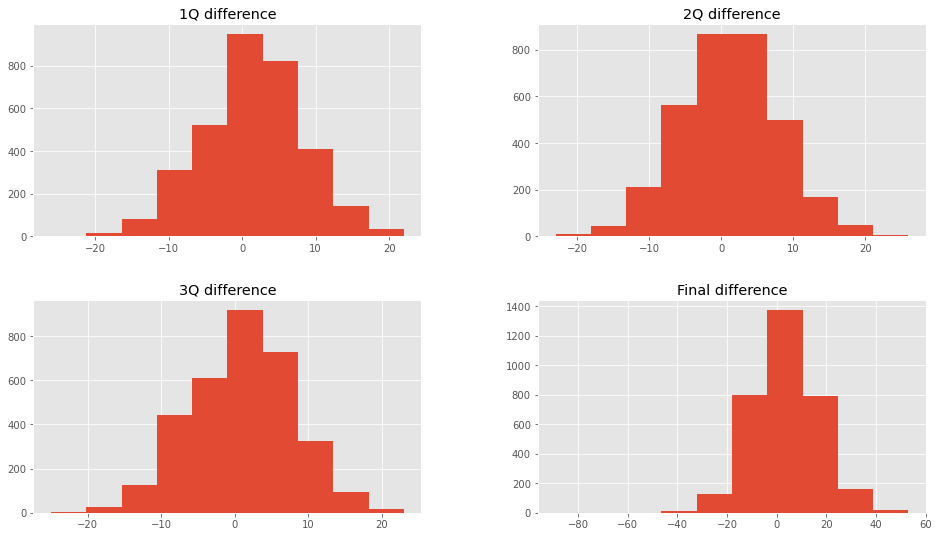

Imagine that we are at the end of the 3Q, and obviusly we have all the stats about what has happended during the game. Could we predict the final difference between the teams? For this purpose, we need to select the features previusly and to create a new ones if needed. Since some of the columns include somehow the variable we want to predict, we will remove them. And what about those important categorical variables such as 'HT' or 'AT'? We'll solve this by using dummy variables.

In [ ]:
#First we remove every row with teams that are not included in
#the list with 10 or more victories.

for team in list_below_10:
    dataset = dataset[~dataset.HT.str.contains(team) & ~dataset.AT.str.contains(team)] 

In [ ]:
#Get the dummy Variables for the categorical variables HT and AT

dummies = pd.get_dummies(dataset[["HT",'AT']]) 

In [ ]:
#Create a new valuable columns for this prediction 

dataset ['1Q difference'] = dataset ['Q1H'] - dataset ['Q1A']
dataset ['2Q difference'] = dataset ['Q2H'] - dataset ['Q2A']
dataset ['3Q difference'] = dataset ['Q3H'] - dataset ['Q3A']
dataset ['Final difference'] = dataset ['HS'] - dataset ['AS']

In [ ]:
#Concatenate it to make a new dataset

dataset =pd.concat([dataset[['1Q difference','2Q difference','3Q difference',
                             'Final difference']],dummies],axis=1) 

## 5.1. KNeighbor. 

In [ ]:
column_list = list(dataset.columns)    # Create a list with the features
column_list.remove('Final difference') # Remove the target variable

In order to get the best possible model, we'll evaluate it with several values of 'k' and we'll use Cross-validation for assessing how the results of our model will generalize to an independent data set.

In [ ]:
hyper_params = [x for x in range(1,30)]
rmse_values = list()
kf = KFold(10, shuffle=True, random_state=1)  
for k in hyper_params:
    knn=KNeighborsRegressor(n_neighbors=k,algorithm='brute')                     
    mses = cross_val_score(knn,dataset[column_list],dataset['Final difference'],
                           scoring = 'neg_mean_squared_error', cv = kf )
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    rmse_values.append(avg_rmse)
    zmin = np.min(rmse_values)
# Scatter plot to visualize the results
print('The lowest rmse=',zmin)
mask = np.array(rmse_values) == zmin
color = np.where(mask, 'red', 'blue')
plt.scatter(hyper_params, rmse_values,color=color)
plt.xticks(np.arange(0, 30, step=1))
plt.show()

In [ ]:
# Check the behaviour of the model removing the dummy variables
hyper_params = [x for x in range(1,25)]
rmse_values = list()
kf = KFold(10, shuffle=True, random_state=1)  
for k in hyper_params:
    knn=KNeighborsRegressor(n_neighbors=k,algorithm='brute')                     
    mses = cross_val_score(knn,dataset[['1Q difference','2Q difference','3Q difference']],dataset['Final difference'],
                           scoring = 'neg_mean_squared_error', cv = kf )
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    rmse_values.append(avg_rmse)
    zmin = np.min(rmse_values)
# Scatter plot to visualize the results
print('The lowest error is rmse=',zmin)
mask = np.array(rmse_values) == zmin
color = np.where(mask, 'red', 'blue')
plt.scatter(hyper_params, rmse_values,color=color)
plt.xticks(np.arange(0, 25, step=1))
plt.show()

The model improves slighly if we do not consider which teams are playing.

## 5.2. LinearRegression.

In [ ]:
dataset_LR = dataset[['1Q difference','2Q difference','3Q difference','Final difference']]

In [ ]:
X = dataset_LR[['1Q difference','2Q difference','3Q difference']]
Y = dataset_LR['Final difference']
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1)
lr = LinearRegression()
lr.fit(x_train,y_train)
test_predictions = lr.predict(x_test)
test_mse =mean_squared_error(test_predictions,y_test)
test_rmse = np.sqrt(test_mse)
print('RMSE: %f'%test_rmse)
from sklearn.metrics import max_error
print('Max error: %f'%max_error(y_test,test_predictions))

## 5.3. Neural Network.

In [ ]:
neurons = [2,5,10,15]
nn_accuracies = []
rmse_list = []
for n in neurons:
    mlp = MLPRegressor(hidden_layer_sizes =(n,n),activation = 'relu',max_iter = 10000)
    mlp.fit(x_train,y_train)
    prediction = mlp.predict(x_test)
    nn_accuracies.append(mlp.score(x_test, y_test))
    mse = mean_squared_error(y_test,prediction)
    rmse = mse**(1/2)
    rmse_list.append(rmse)
    

print('RMSE: %f'%statistics.mean(rmse_list))
print('Max error: %f'%max_error(y_test,prediction))

## 5.4. RandomForestRegressor.

In [ ]:
model = RandomForestRegressor()
model.fit(x_train,y_train)
# Get the mean absolute error on the validation data
predicted_prices = model.predict(x_test)
rmse = mean_squared_error(y_test , predicted_prices)**(1/2)
print('RMSE = ', rmse)
print('Max error: %f'%max_error(y_test,predicted_prices))

# 6. Conclusion

In the sections two and three, it was shown that the consistency is what distinguishes average teams from the best ones. We found that the top teams were able to win anywhere, unlike bad teams, which tend to win when playing at home.
In section four, we observed that in the past few years there seems to be a higher score. We cannot ensure that this increase will continue in the coming years.
Finally, our best prediction was using the Linear Regression which is generally good for predicting continuous values. The Neural Network had a very similar performance, probably due to its capability to identify non linear relationship, in this case there is no linear relation between our features and the target variable.
